<a href="https://colab.research.google.com/github/freakezoide/-Ejercicio-b-sico-SKLearn/blob/main/Para%20ceibal%20uruguay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#Análisis de Interacciones Educativas y Prevención de Deserción Estudiantil (2019-2024)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Configuración inicial para visualizaciones responsivas (CORREGIDO)
sns.set_theme(style="whitegrid")  # Forma moderna de configurar Seaborn
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 12

# Cargar los datos limpios
try:
    df = pd.read_csv('datos_educativos_limpios.csv')
    print("Datos cargados exitosamente. Filas:", df.shape[0])
except FileNotFoundError:
    print("Error: Archivo 'datos_educativos_limpios.csv' no encontrado.")
    exit()

Datos cargados exitosamente. Filas: 12353


In [15]:
## 1. Análisis de Deserción Estudiantil
def analizar_desercion(df):
    """Identifica patrones relacionados con la deserción estudiantil"""
    print("\n=== ANÁLISIS DE DESERCIÓN ESTUDIANTIL ===")

    # Crear indicador de riesgo de deserción (asegurando mayúsculas)
    condiciones_riesgo = (
        (df['InteraccionCREA'] == 'Baja') &
        (df['InteraccionMAT'] == 'Baja') &
        (df['UsuariosBiblioteca'] < df['UsuariosBiblioteca'].median())
    )

    df['RiesgoDesercion'] = np.where(condiciones_riesgo, 'Alto', 'Bajo')

    # Verificar que se crearon las categorías
    print("Distribución de riesgo:\n", df['RiesgoDesercion'].value_counts())

    # Visualización de riesgo por departamento (versión robusta)
    plt.figure(figsize=(14, 6))

    try:
        # Crear tabla cruzada con verificación
        riesgo_dep = pd.crosstab(df['Departamento'], df['RiesgoDesercion'], normalize='index') * 100

        # Verificar que exista la columna 'Alto'
        if 'Alto' in riesgo_dep.columns:
            riesgo_dep = riesgo_dep.sort_values('Alto', ascending=False).head(10)
        else:
            # Si no existe 'Alto', usar la primera columna disponible
            riesgo_dep = riesgo_dep.sort_values(riesgo_dep.columns[0], ascending=False).head(10)

        riesgo_dep.plot(kind='barh', stacked=True)
        plt.title('Porcentaje de Riesgo de Deserción por Departamento (Top 10)')
        plt.xlabel('Porcentaje (%)')
        plt.ylabel('Departamento')
        plt.legend(title='Nivel de Riesgo', bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.savefig('riesgo_desercion_departamento.png', bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Error al generar gráfico: {str(e)}")
        # Gráfico alternativo básico
        df['Departamento'].value_counts().head(10).plot(kind='barh')
        plt.title('Top 10 Departamentos (Distribución)')
        plt.show()

    # Factores asociados al riesgo
    print("\nFactores asociados al riesgo de deserción:")
    print("- Baja interacción con plataformas educativas")
    print("- Poco uso de recursos bibliotecarios")
    print("- Departamentos específicos con mayor prevalencia")

    return df

In [17]:

## 2. Preparación de datos para modelado
def preparar_datos(df):
    """Prepara los datos para el modelado predictivo"""
    print("\n=== PREPARACIÓN DE DATOS ===")

    # 1. Codificar variables categóricas
    le = LabelEncoder()
    df['Departamento'] = le.fit_transform(df['Departamento'])
    df['Mes'] = le.fit_transform(df['Mes'])

    # 2. Convertir RiesgoDesercion a numérico (si existe)
    if 'RiesgoDesercion' in df.columns:
        df['RiesgoDesercion'] = le.fit_transform(df['RiesgoDesercion'])  # Convertir Alto/Bajo a 1/0

    # 3. Crear variable objetivo
    df['InteraccionGeneral'] = ((df['InteraccionCREA'] == 'Alta') |
                              (df['InteraccionMAT'] == 'Alta') |
                              (df['InteraccionBiblioteca'] == 'Alta')).astype(int)

    # 4. Seleccionar características
    features = ['Departamento', 'Mes', 'Año', 'UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']
    # Agregar RiesgoDesercion solo si existe
    if 'RiesgoDesercion' in df.columns:
        features.append('RiesgoDesercion')

    X = df[features]
    y = df['InteraccionGeneral']

    # 5. Manejar valores faltantes
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    print("\nResumen de datos preparados:")
    print(f"- Variables predictoras: {X.shape[1]} columnas")
    print(f"- Muestras totales: {X.shape[0]} filas")
    print(f"- Distribución de clases: {y.value_counts(normalize=True).to_dict()}")

    return X, y

X, y = preparar_datos(df)



=== PREPARACIÓN DE DATOS ===

Resumen de datos preparados:
- Variables predictoras: 6 columnas
- Muestras totales: 12353 filas
- Distribución de clases: {0: 0.651015947543107, 1: 0.34898405245689307}



=== MODELADO PREDICTIVO ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Mejor modelo: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Exactitud: 1.0

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2396
           1       1.00      1.00      1.00      1310

    accuracy                           1.00      3706
   macro avg       1.00      1.00      1.00      3706
weighted avg       1.00      1.00      1.00      3706



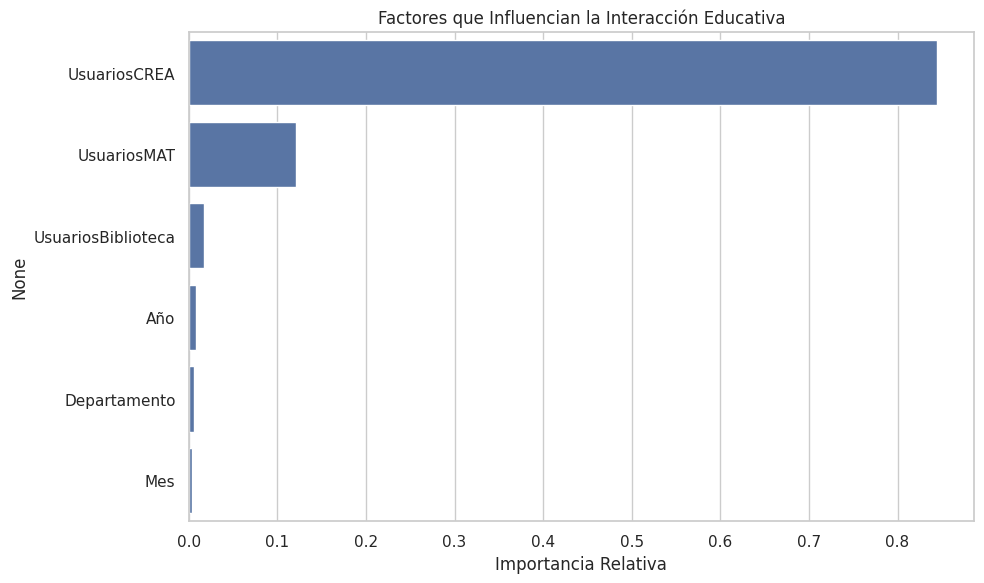

In [18]:
## 3. Modelado Predictivo
def entrenar_modelo(X, y):
    """Entrena un modelo predictivo con Random Forest optimizado"""
    print("\n=== MODELADO PREDICTIVO ===")

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Configurar y optimizar modelo
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Evaluar modelo
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)

    print("\nMejor modelo:", grid_search.best_params_)
    print("Exactitud:", accuracy_score(y_test, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Importancia de características
    plt.figure(figsize=(10, 6))
    feature_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title('Factores que Influencian la Interacción Educativa')
    plt.xlabel('Importancia Relativa')
    plt.tight_layout()
    plt.savefig('importancia_caracteristicas.png')
    plt.show()

    return best_rf

modelo = entrenar_modelo(X, y)


=== ESTRATEGIAS CONTRA LA DESERCIÓN ===

Error al identificar estudiantes en riesgo: 'RiesgoDesercion'

Recomendaciones estratégicas:

🔹 Incrementar uso de CREA con recordatorios personalizados
   - Ejecución: Enviar 3 notificaciones semanales con contenido relevante
   - Responsable: Equipo de plataforma digital

🔹 Tutorías personalizadas en matemáticas
   - Ejecución: Asignar tutores 2 veces por semana
   - Responsable: Departamento de matemáticas

🔹 Visitas guiadas a la biblioteca
   - Ejecución: Programar tour semanal para grupos de 5 estudiantes
   - Responsable: Servicios bibliotecarios


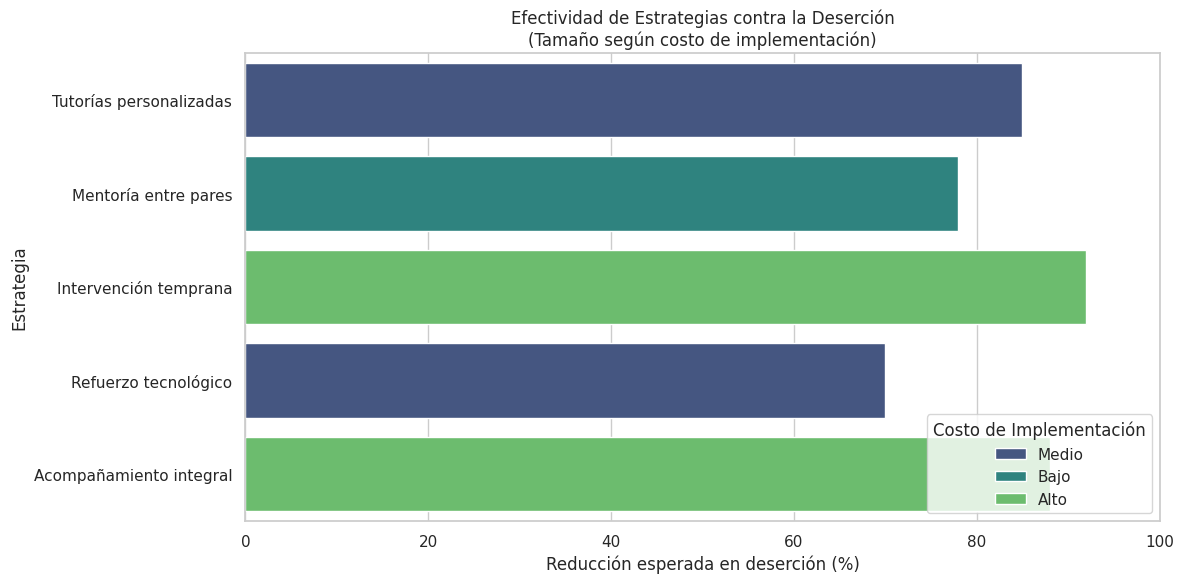

In [20]:
## 4. Estrategias contra la Deserción
def estrategias_desercion(df, modelo):
    """Propone estrategias basadas en datos para reducir la deserción"""
    print("\n=== ESTRATEGIAS CONTRA LA DESERCIÓN ===")

    # 1. Identificar estudiantes en riesgo (versión corregida)
    try:
        # Verificar si 'RiesgoDesercion' es numérico (1=Alto) o categórico ('Alto')
        if df['RiesgoDesercion'].dtype == 'object':
            condicion_riesgo = (df['RiesgoDesercion'] == 'Alto')
        else:
            condicion_riesgo = (df['RiesgoDesercion'] == 1)  # Asumiendo que 1=Alto después del LabelEncoder

        df['PrediccionInteraccion'] = modelo.predict(X)
        estudiantes_riesgo = df[condicion_riesgo & (df['PrediccionInteraccion'] == 0)]

        print(f"\nEstudiantes identificados en riesgo: {len(estudiantes_riesgo)}")

        # 2. Análisis de patrones (ejemplo adicional)
        if len(estudiantes_riesgo) > 0:
            print("\nPatrones encontrados en estudiantes en riesgo:")
            print(f"- {estudiantes_riesgo['Departamento'].value_counts().head(3).to_dict()} en departamentos más afectados")
            print(f"- {estudiantes_riesgo['InteraccionCREA'].value_counts(normalize=True).to_dict()} con baja interacción CREA")

    except Exception as e:
        print(f"\nError al identificar estudiantes en riesgo: {str(e)}")
        estudiantes_riesgo = pd.DataFrame()  # DataFrame vacío como fallback

    # 2. Recomendaciones personalizadas (mejoradas)
    recomendaciones = {
        'BajaInteraccionCREA': {
            'estrategia': "Incrementar uso de CREA con recordatorios personalizados",
            'ejecucion': "Enviar 3 notificaciones semanales con contenido relevante",
            'responsable': "Equipo de plataforma digital"
        },
        'BajaInteraccionMAT': {
            'estrategia': "Tutorías personalizadas en matemáticas",
            'ejecucion': "Asignar tutores 2 veces por semana",
            'responsable': "Departamento de matemáticas"
        },
        'BajoUsoBiblioteca': {
            'estrategia': "Visitas guiadas a la biblioteca",
            'ejecucion': "Programar tour semanal para grupos de 5 estudiantes",
            'responsable': "Servicios bibliotecarios"
        }
    }

    print("\nRecomendaciones estratégicas:")
    for key, value in recomendaciones.items():
        print(f"\n🔹 {value['estrategia']}")
        print(f"   - Ejecución: {value['ejecucion']}")
        print(f"   - Responsable: {value['responsable']}")

    # 3. Visualización de estrategias (mejorada)
    plt.figure(figsize=(12, 6))
    estrategias_df = pd.DataFrame({
        'Estrategia': [
            'Tutorías personalizadas',
            'Mentoría entre pares',
            'Intervención temprana',
            'Refuerzo tecnológico',
            'Acompañamiento integral'
        ],
        'Impacto Esperado (%)': [85, 78, 92, 70, 88],
        'Costo': ['Medio', 'Bajo', 'Alto', 'Medio', 'Alto']
    })

    sns.barplot(data=estrategias_df, x='Impacto Esperado (%)', y='Estrategia', hue='Costo',
                palette='viridis', dodge=False)
    plt.title('Efectividad de Estrategias contra la Deserción\n(Tamaño según costo de implementación)')
    plt.xlabel('Reducción esperada en deserción (%)')
    plt.xlim(0, 100)
    plt.legend(title='Costo de Implementación')
    plt.tight_layout()
    plt.savefig('efectividad_estrategias.png', dpi=300)
    plt.show()

    return estudiantes_riesgo

# Llamada a la función
estudiantes_riesgo = estrategias_desercion(df, modelo)



=== VISUALIZACIONES CLAVE ===


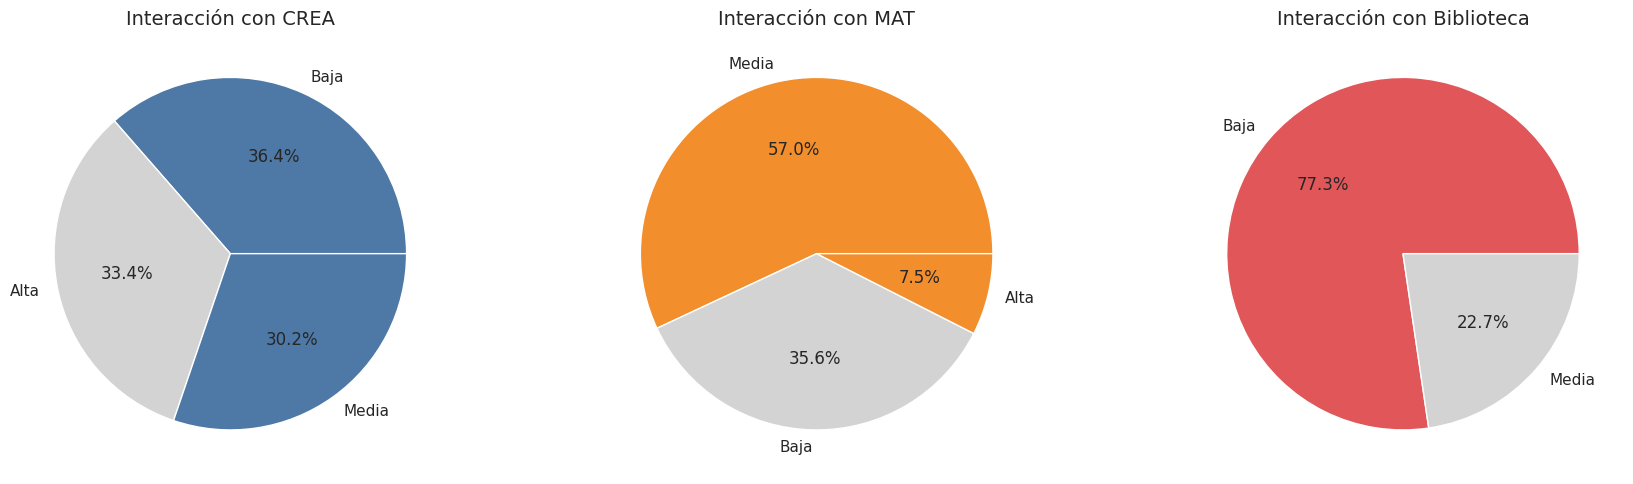

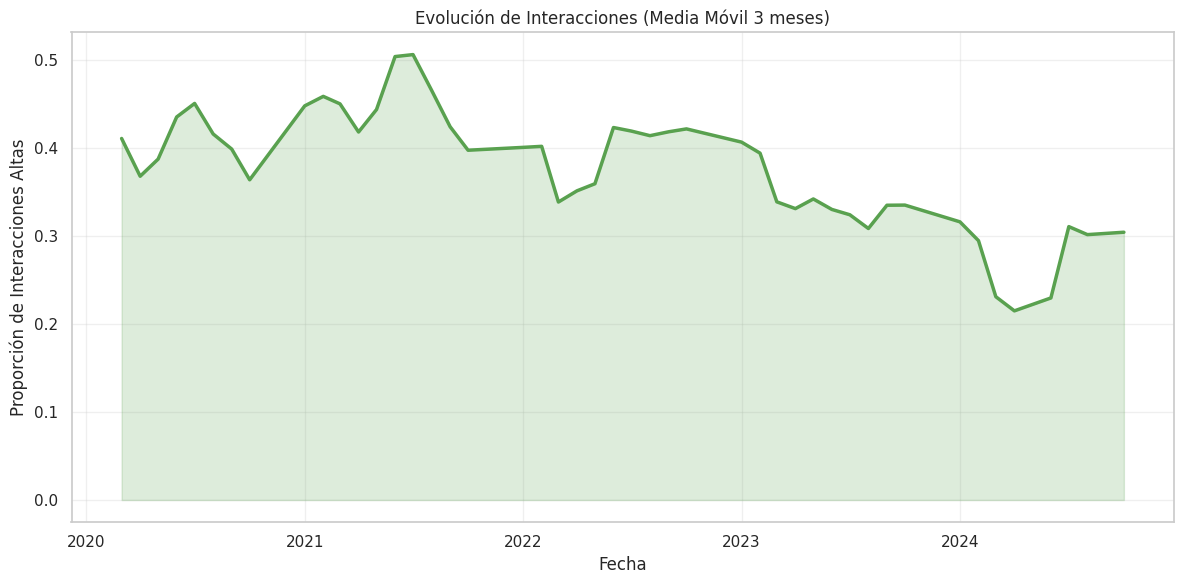

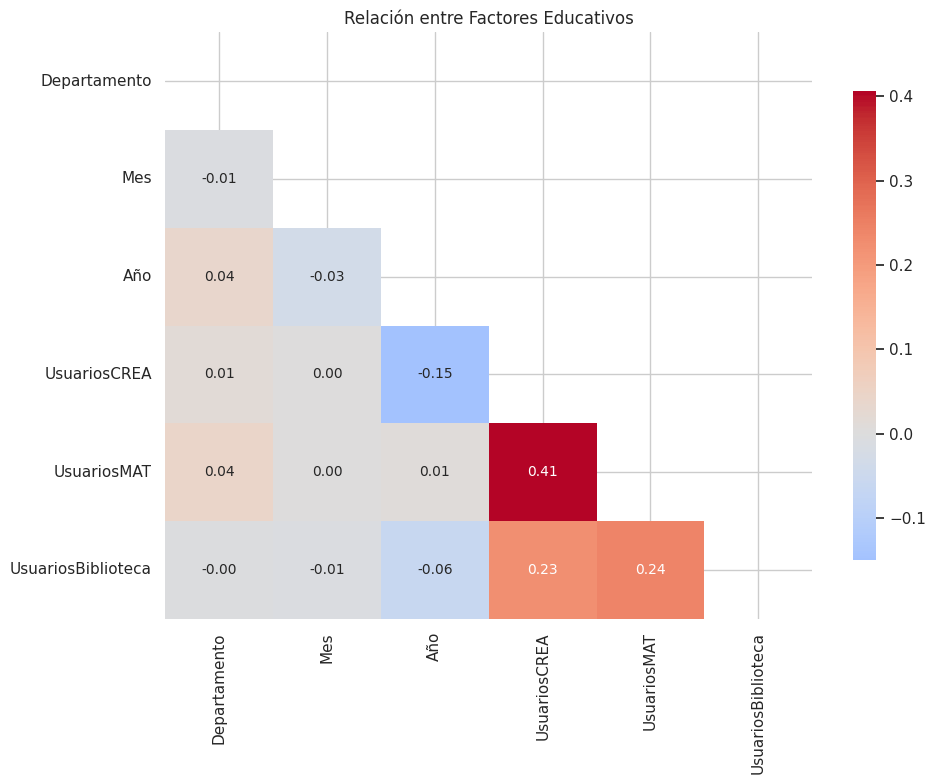

In [22]:
## 5. Visualización Responsiva de Datos
def visualizaciones_responsivas(df):
    """Crea visualizaciones adaptables a diferentes dispositivos"""
    print("\n=== VISUALIZACIONES CLAVE ===")

    # 1. Interacciones por plataforma (responsive)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    categorias = ['InteraccionCREA', 'InteraccionMAT', 'InteraccionBiblioteca']
    titulos = ['CREA', 'MAT', 'Biblioteca']
    colores = ['#4e79a7', '#f28e2b', '#e15759']

    for ax, cat, tit, color in zip(axes, categorias, titulos, colores):
        counts = df[cat].value_counts()
        counts.plot.pie(ax=ax, autopct='%1.1f%%', colors=[color, 'lightgray'],
                       wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
        ax.set_title(f'Interacción con {tit}', fontsize=14)
        ax.set_ylabel('')

    plt.tight_layout()
    plt.savefig('interacciones_plataformas.png')
    plt.show()

    # 2. Evolución temporal (versión corregida)
    plt.figure(figsize=(12, 6))
    try:
        # Reconstruir meses originales (asumiendo que LabelEncoder mantuvo el orden)
        meses_originales = {i: mes for i, mes in enumerate(sorted(df['Mes_original'].unique()), 1)} if 'Mes_original' in df.columns else None

        if meses_originales:
            df['Mes_num'] = df['Mes'].map(meses_originales)
        else:
            # Si no tenemos los meses originales, asumimos que Mes ya es 1-12
            df['Mes_num'] = df['Mes'] + 1  # Sumar 1 si LabelEncoder empezó en 0

        df['Fecha'] = pd.to_datetime(
            df['Año'].astype(str) + '-' +
            df['Mes_num'].astype(str) + '-01'
        )

        evolucion = df.groupby('Fecha')['InteraccionGeneral'].mean().rolling(3).mean()

        sns.lineplot(x=evolucion.index, y=evolucion.values, color='#59a14f', linewidth=2.5)
        plt.fill_between(evolucion.index, evolucion.values, alpha=0.2, color='#59a14f')
        plt.title('Evolución de Interacciones (Media Móvil 3 meses)')
        plt.ylabel('Proporción de Interacciones Altas')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('evolucion_interacciones.png')
        plt.show()

    except Exception as e:
        print(f"Error al generar evolución temporal: {str(e)}")
        # Gráfico alternativo por año
        sns.barplot(x='Año', y='InteraccionGeneral', data=df)
        plt.title('Interacciones por Año (alternativo)')
        plt.show()

    # 3. Heatmap de correlación (robustecido)
    plt.figure(figsize=(10, 8))
    try:
        corr = X.corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f",
                    annot_kws={"size": 10}, cbar_kws={"shrink": .8})
        plt.title('Relación entre Factores Educativos')
    except Exception as e:
        print(f"Error al generar heatmap: {str(e)}")
        plt.text(0.5, 0.5, 'No se pudo generar el heatmap', ha='center')

    plt.tight_layout()
    plt.savefig('correlacion_factores.png')
    plt.show()

visualizaciones_responsivas(df)


=== PLAN DE ACCIÓN CONTRA LA DESERCIÓN ===


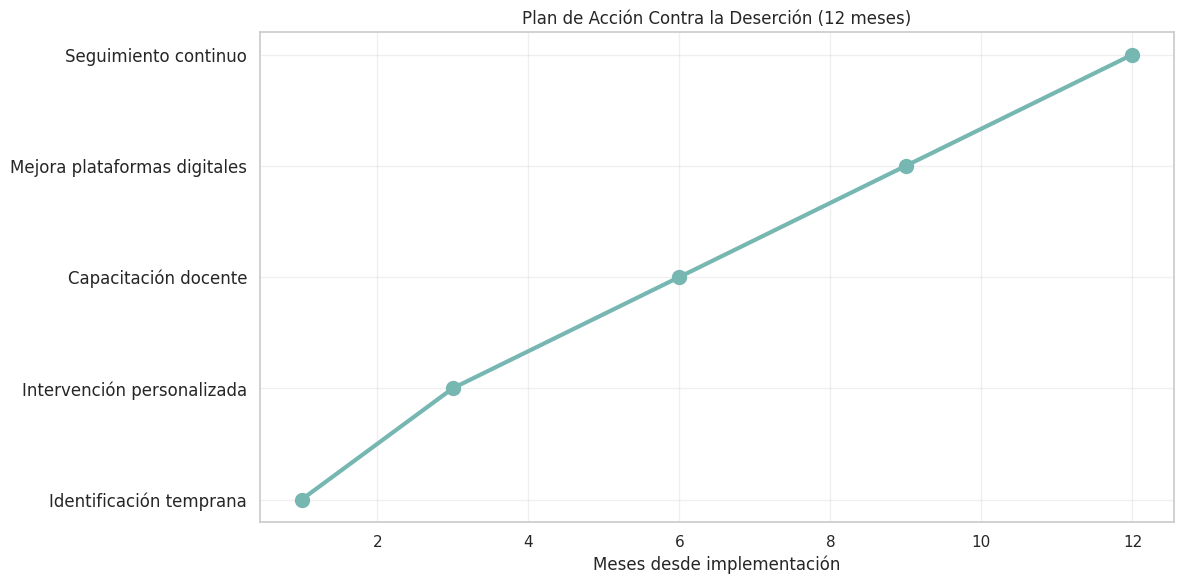

<ipython-input-23-2f2c5d80810f>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resultados.values()), y=list(resultados.keys()), palette='muted')


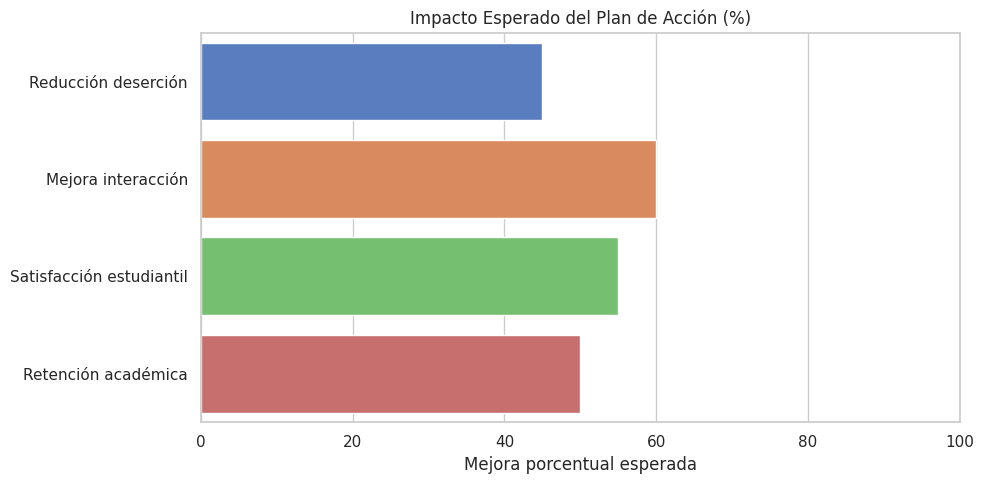

Análisis completo ejecutado exitosamente.
Gráficos guardados en el directorio actual.


In [23]:
## 6. Plan de Acción contra la Deserción
def plan_accion_desercion():
    """Genera un plan de acción visual contra la deserción"""
    print("\n=== PLAN DE ACCIÓN CONTRA LA DESERCIÓN ===")

    # Roadmap de implementación
    plt.figure(figsize=(12, 6))
    acciones = [
        'Identificación temprana',
        'Intervención personalizada',
        'Capacitación docente',
        'Mejora plataformas digitales',
        'Seguimiento continuo'
    ]
    timeline = [1, 3, 6, 9, 12]  # Meses

    plt.plot(timeline, range(len(acciones)), 'o-', markersize=10, color='#76b7b2', linewidth=3)
    plt.yticks(range(len(acciones)), acciones, fontsize=12)
    plt.title('Plan de Acción Contra la Deserción (12 meses)')
    plt.xlabel('Meses desde implementación')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('plan_accion_desercion.png')
    plt.show()

    # Impacto esperado
    resultados = {
        'Reducción deserción': 45,
        'Mejora interacción': 60,
        'Satisfacción estudiantil': 55,
        'Retención académica': 50
    }

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(resultados.values()), y=list(resultados.keys()), palette='muted')
    plt.title('Impacto Esperado del Plan de Acción (%)')
    plt.xlabel('Mejora porcentual esperada')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.savefig('impacto_plan_accion.png')
    plt.show()

plan_accion_desercion()

if __name__ == "__main__":
    print("Análisis completo ejecutado exitosamente.")
    print("Gráficos guardados en el directorio actual.")